In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, LSTMCell, Lambda, Reshape, RNN


In [5]:
print(tf.__version__)

2.3.1


In [6]:
tf.random.set_seed(51)
np.random.seed(51)

In [7]:
df = pd.read_csv('energydata_complete.csv')
df.head(10)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,...,17.000000,45.29,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,...,17.000000,45.29,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,...,17.000000,45.29,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,...,17.000000,45.29,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.23,44.400000,19.79,44.863333,18.890000,...,17.000000,45.29,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


Converting data from every 10 minutes to an hourly format

In [8]:
df = df[::6] #Data is now of an hourly form

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [9]:
df.shape

(3290, 29)

In [10]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

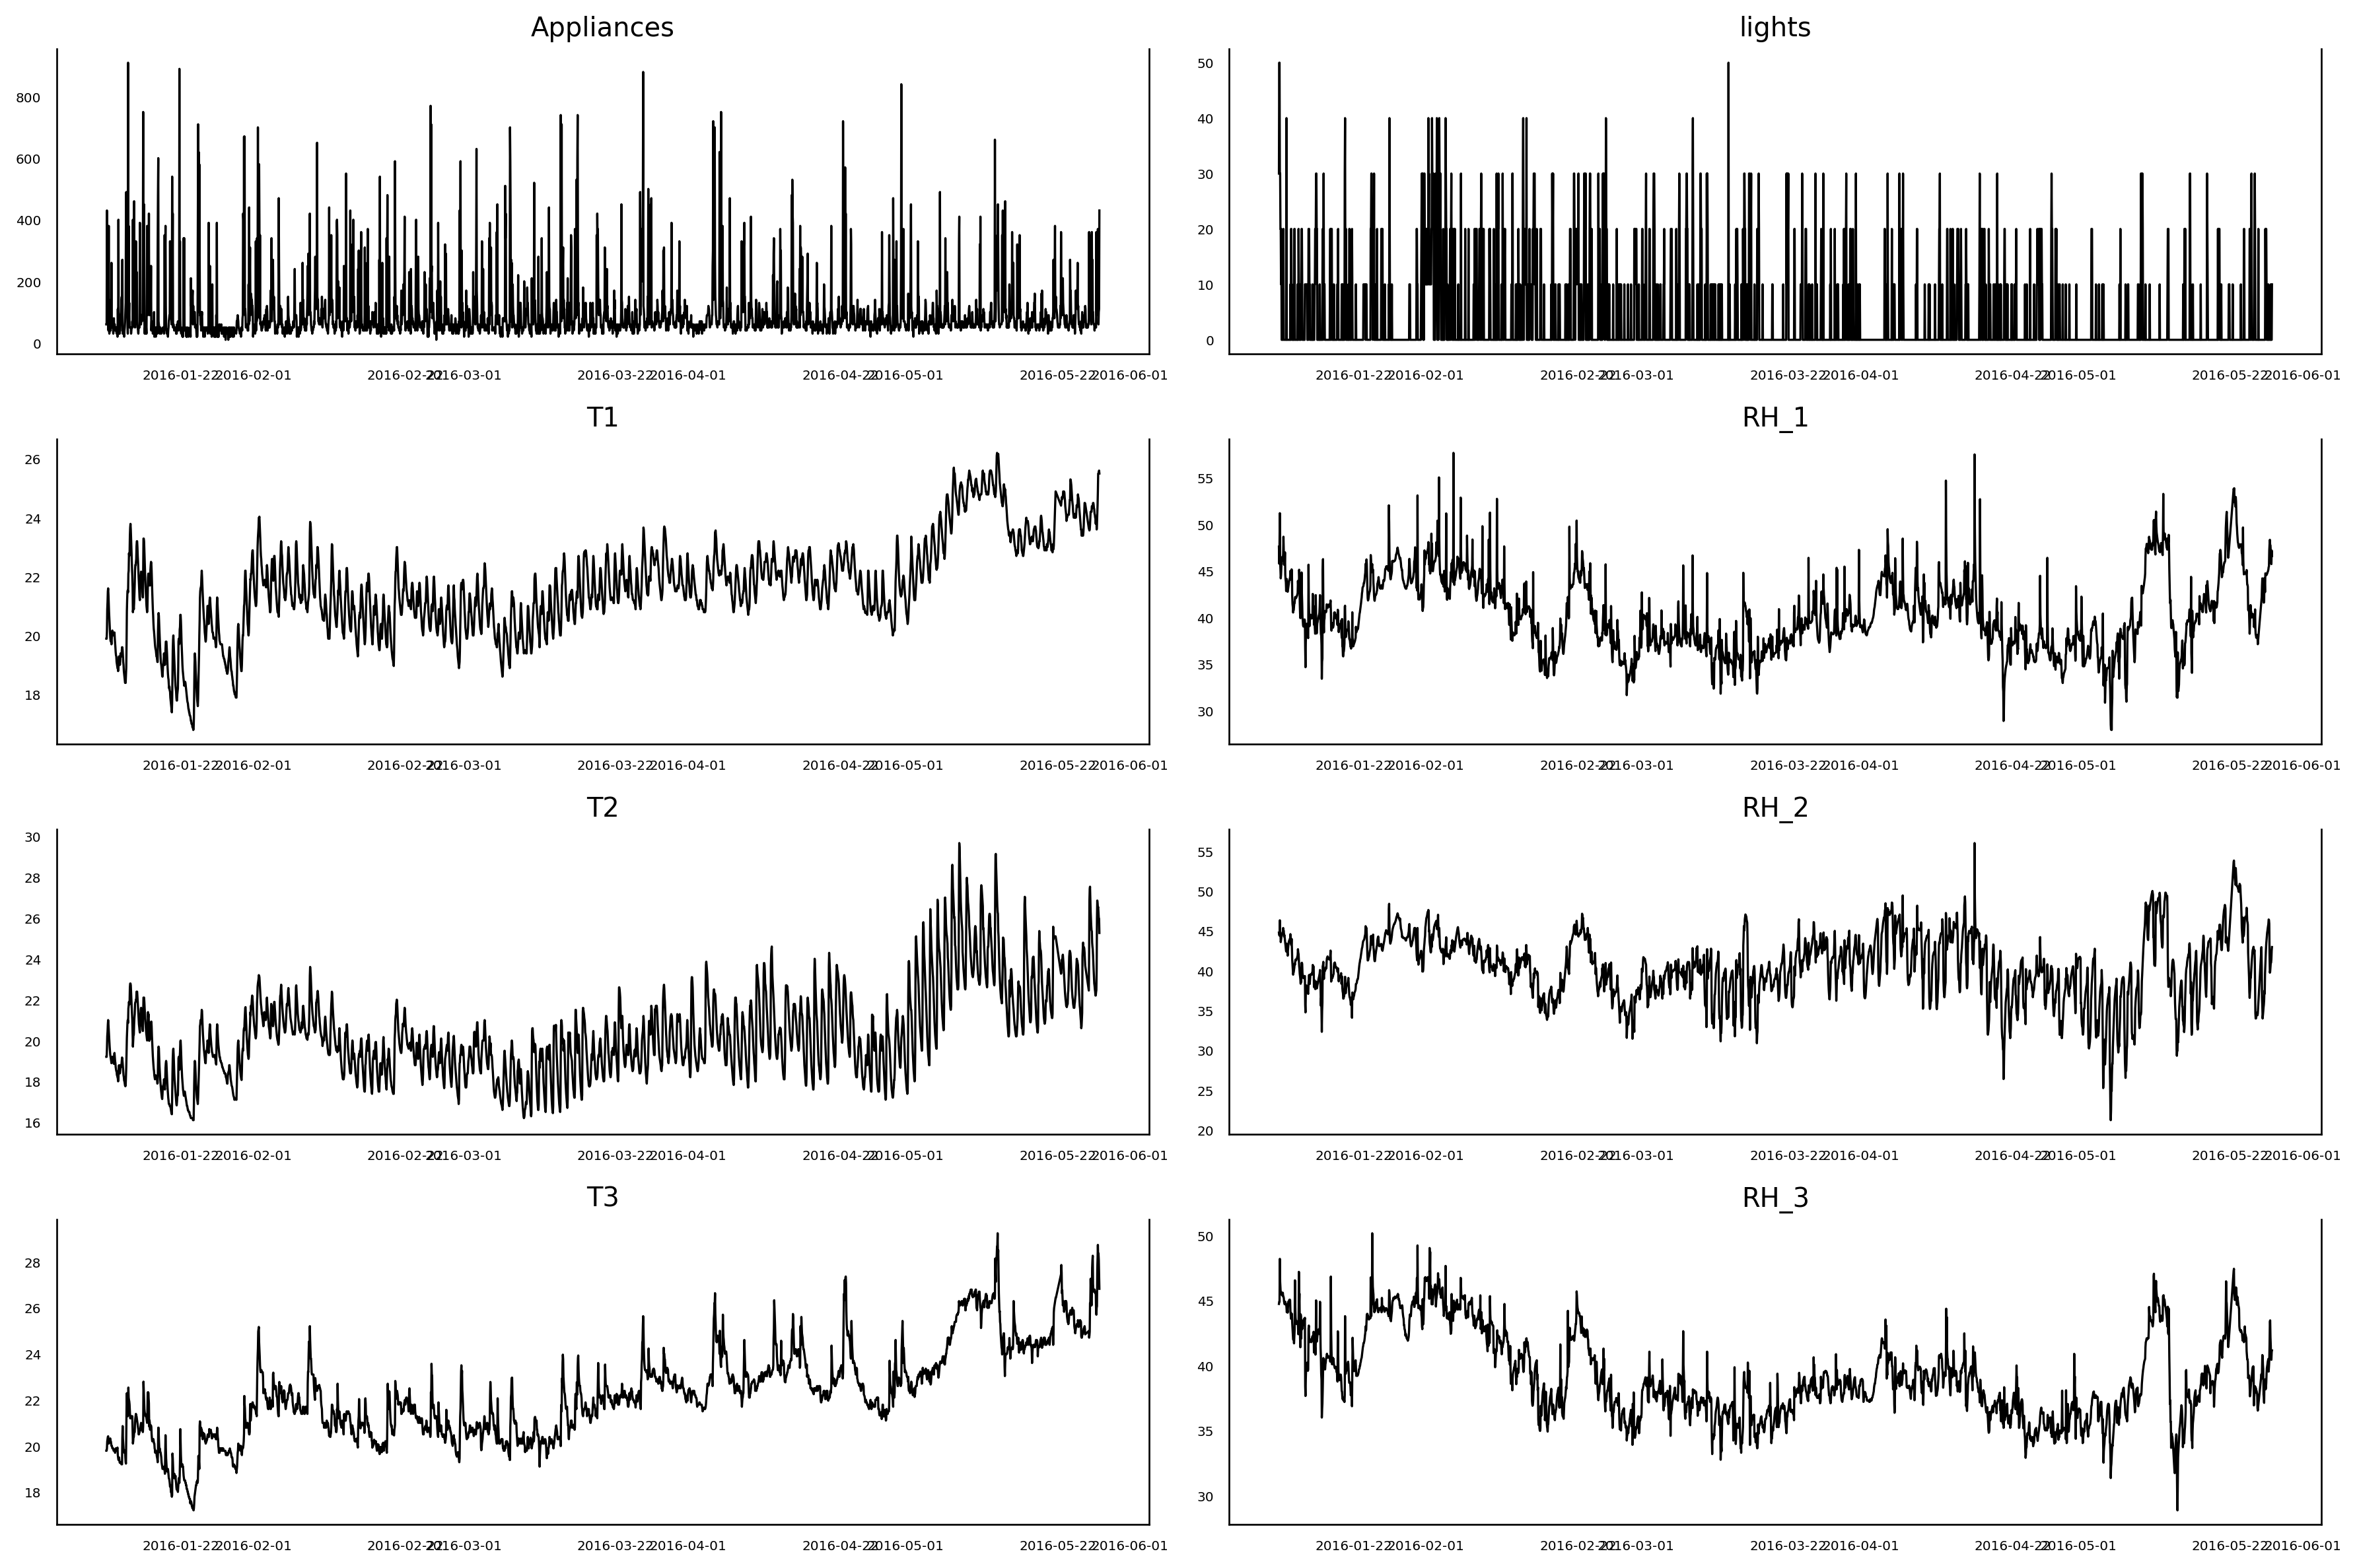

In [11]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, dpi = 240, figsize = (15,10))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color = 'black', linewidth = 1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()


EDA

In [12]:

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


In [13]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis = 1)

In [14]:
df.shape

(3290, 25)

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333
T5,3290.0,19.593729,1.846567,15.335000,18.290000,19.390000,20.613492,25.466667


Splitting into training, validation, and test set

In [16]:
#Split data in training, validation , and test-set

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

#Split 70:20:10

train_df = df[0: int(n*0.7)]

val_df = df[int(n*0.7): int(n*0.9)]

test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 25 features


Normalizing data (make it easier for DL models for training)

In [17]:

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/ train_std

val_df = (val_df - train_mean)/ train_std

test_df = (test_df - train_mean)/ train_std

#Only training set's descriptive statisitics are used since validation and test set stats should not affect the model

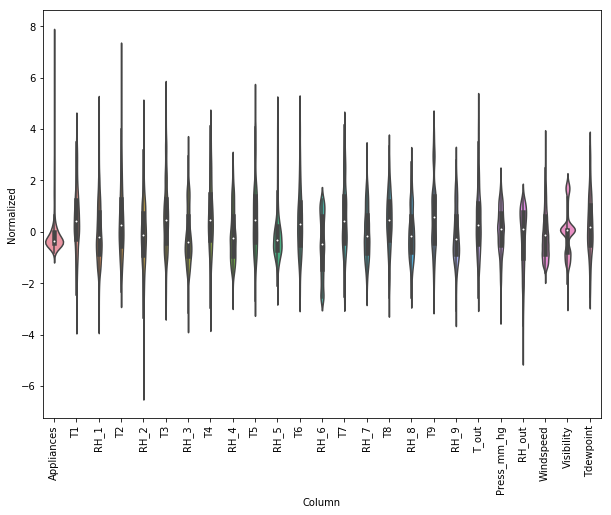

In [18]:
df_std = (df - train_mean)/ train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

#Violin Plot

ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)

_ = ax.set_xticklabels(df.keys(), rotation = 90)

It can be seen that the distributions for each of the data columns are not reaching normality after normalization
 

# Data Windowing

In [19]:
#Data Windowing (From tensorflow website)
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

        #feeds the data into the neural network

Setting up parameters for any model

In [20]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience = 3):
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

    model.compile(loss = MeanSquaredError(),
                    optimizer = Adam(),
                    metrics = [MeanAbsoluteError()])

    history = model.fit(window.train,
                        epochs  = MAX_EPOCHS,
                        validation_data = window.val,
                        callbacks = [early_stopping])

    return history

    #Fits the data

Baseline Model that assumes the predicted value is same as the previous value


In [21]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

In [22]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [23]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=MeanSquaredError(),
                metrics=[MeanAbsoluteError()])

In [24]:
#Store performances in a dictionary
val_performance = {}

performance ={}

In [25]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 2ms/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [26]:

wide_window = WindowGenerator(input_width=24, label_width= 24, shift= 1, label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

In [27]:
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose = 0)

20/20 [==============================] - 0s 6ms/step - loss: 0.7513 - mean_absolute_error: 0.3776


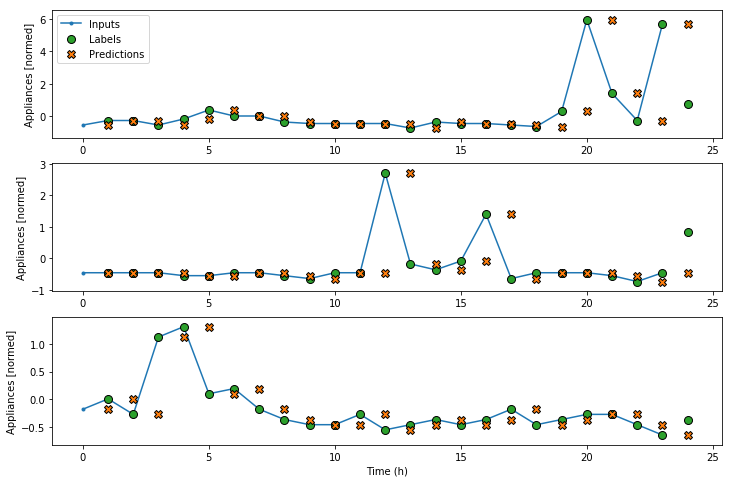

In [28]:
wide_window.plot(baseline)

# Linear Model

In [29]:
#Linear Model
linear = Sequential([
    Dense(units = 1)
])

In [30]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)

performance['Linear'] = linear.evaluate(single_step_window.test, verbose = 0)

Epoch 1/50
72/72 [==============================] - 1s 10ms/step - loss: 1.4372 - mean_absolute_error: 0.8390 - val_loss: 0.9588 - val_mean_absolute_error: 0.6821
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 1.1017 - mean_absolute_error: 0.6830 - val_loss: 0.8499 - val_mean_absolute_error: 0.6328
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 1.0234 - mean_absolute_error: 0.6325 - val_loss: 0.7536 - val_mean_absolute_error: 0.5772
Epoch 4/50
72/72 [==============================] - 0s 5ms/step - loss: 0.9862 - mean_absolute_error: 0.6057 - val_loss: 0.7083 - val_mean_absolute_error: 0.5473
Epoch 5/50
72/72 [==============================] - 1s 7ms/step - loss: 0.9637 - mean_absolute_error: 0.5904 - val_loss: 0.6655 - val_mean_absolute_error: 0.5087
Epoch 6/50
72/72 [==============================] - 0s 4ms/step - loss: 0.9470 - mean_absolute_error: 0.5771 - val_loss: 0.6408 - val_mean_absolute_error: 0.4884
Epoch 7/50
72/72 [=========

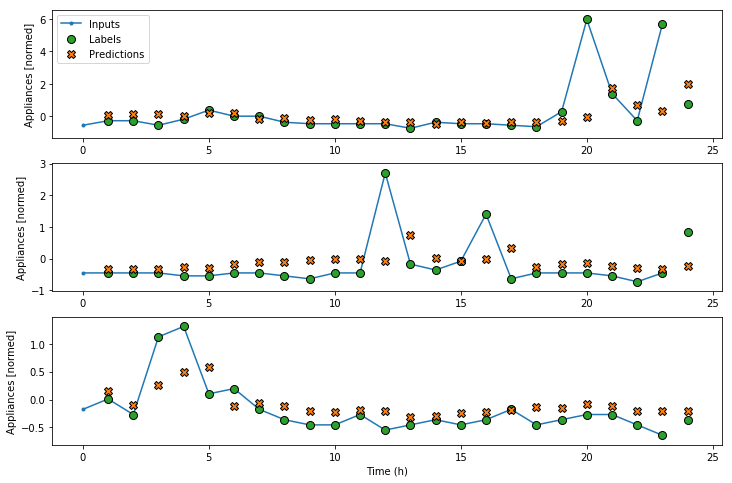

In [31]:
wide_window.plot(linear)

# Dense Neural Network (Single Step Window)



In [32]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/50
72/72 [==============================] - 1s 11ms/step - loss: 0.9463 - mean_absolute_error: 0.5665 - val_loss: 0.6094 - val_mean_absolute_error: 0.4204
Epoch 2/50
72/72 [==============================] - 0s 5ms/step - loss: 0.8512 - mean_absolute_error: 0.5209 - val_loss: 0.5987 - val_mean_absolute_error: 0.4207
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 0.8258 - mean_absolute_error: 0.5141 - val_loss: 0.6523 - val_mean_absolute_error: 0.4626
Epoch 4/50
72/72 [==============================] - 0s 5ms/step - loss: 0.7911 - mean_absolute_error: 0.5011 - val_loss: 0.5487 - val_mean_absolute_error: 0.4052
Epoch 5/50
72/72 [==============================] - 0s 4ms/step - loss: 0.7756 - mean_absolute_error: 0.4976 - val_loss: 0.5580 - val_mean_absolute_error: 0.4576
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.7590 - mean_absolute_error: 0.4924 - val_loss: 0.5557 - val_mean_absolute_error: 0.4064
Epoch 7/50
72/72 [=========

# CNN 
with wide window


In [33]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [34]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [35]:
cnn_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 0s 5ms/step - loss: 0.9859 - mean_absolute_error: 0.5793 - val_loss: 0.6811 - val_mean_absolute_error: 0.4684
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.8512 - mean_absolute_error: 0.5279 - val_loss: 0.6541 - val_mean_absolute_error: 0.4611
Epoch 3/50
72/72 [==============================] - 0s 4ms/step - loss: 0.7989 - mean_absolute_error: 0.5066 - val_loss: 0.6624 - val_mean_absolute_error: 0.4613
Epoch 4/50
72/72 [==============================] - 0s 4ms/step - loss: 0.7751 - mean_absolute_error: 0.4955 - val_loss: 0.7379 - val_mean_absolute_error: 0.4996
Epoch 5/50
21/21 [==============================] - 0s 3ms/step - loss: 0.6812 - mean_absolute_error: 0.4660


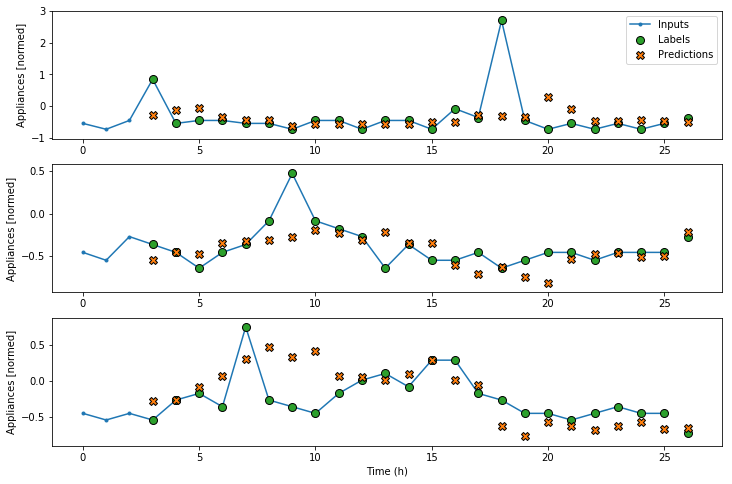

In [36]:
wide_conv_window.plot(cnn_model)


# LSTM

In [37]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 19ms/step - loss: 0.9250 - mean_absolute_error: 0.5556 - val_loss: 0.5430 - val_mean_absolute_error: 0.3882
Epoch 2/50
72/72 [==============================] - 1s 12ms/step - loss: 0.7829 - mean_absolute_error: 0.5001 - val_loss: 0.5394 - val_mean_absolute_error: 0.4061
Epoch 3/50
72/72 [==============================] - 1s 17ms/step - loss: 0.7192 - mean_absolute_error: 0.4781 - val_loss: 0.5498 - val_mean_absolute_error: 0.4138
Epoch 4/50
72/72 [==============================] - 1s 18ms/step - loss: 0.6721 - mean_absolute_error: 0.4638 - val_loss: 0.5542 - val_mean_absolute_error: 0.4243
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.5477 - mean_absolute_error: 0.4194


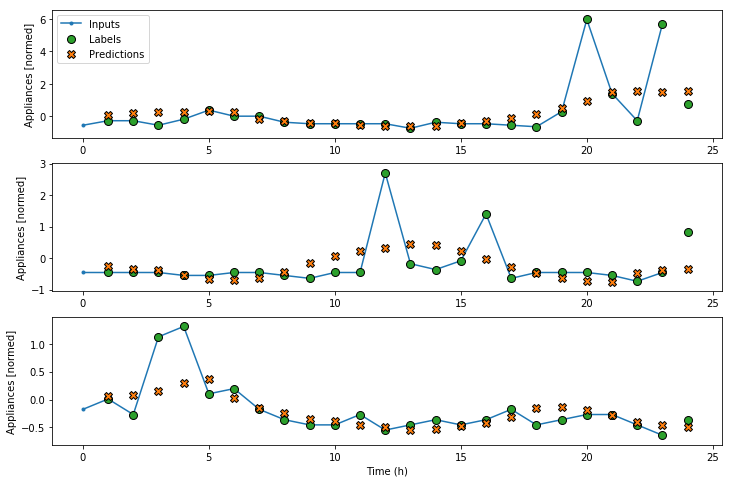

In [38]:
wide_window.plot(lstm_model)


# CNN+LSTM

In [39]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 28ms/step - loss: 0.9859 - mean_absolute_error: 0.5887 - val_loss: 0.5952 - val_mean_absolute_error: 0.4904
Epoch 2/50
72/72 [==============================] - 1s 10ms/step - loss: 0.8958 - mean_absolute_error: 0.5281 - val_loss: 0.5229 - val_mean_absolute_error: 0.3702
Epoch 3/50
72/72 [==============================] - 1s 13ms/step - loss: 0.8071 - mean_absolute_error: 0.4936 - val_loss: 0.5433 - val_mean_absolute_error: 0.3490
Epoch 4/50
72/72 [==============================] - 1s 12ms/step - loss: 0.7811 - mean_absolute_error: 0.4860 - val_loss: 0.5572 - val_mean_absolute_error: 0.3533
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5298 - mean_absolute_error: 0.3483


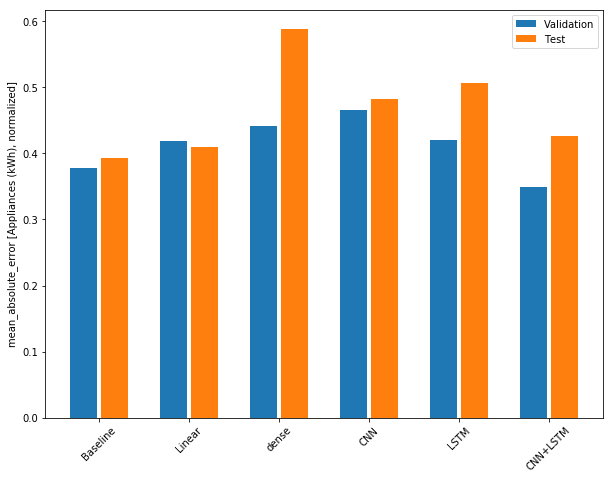

In [40]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Appliances (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [41]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.3934
Linear: 0.4095
dense: 0.5875
CNN: 0.4823
LSTM: 0.5057
CNN+LSTM: 0.4261
